# Naive approach catboost + optuna

In [30]:
model_name = 'catboost_optuna'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

df_train['date'] = pd.to_datetime(df_train['date'])

df_train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [3]:
def create_features(df):
    # split date into year, month, day
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # week number
    df['week_number'] = df['date'].dt.isocalendar().week.astype(int)



    # day of week
    df['dayofweek'] = df['date'].dt.dayofweek

    # weekend
    df['weekend'] = (df['date'].dt.weekday >=4).astype(int)

    # drop date
    df = df.drop('date', axis=1)

    # one-hot encoding of 'country', 'store', 'product' columns
    #df_train = pd.get_dummies(df_train, columns=['country', 'store', 'product'])


    df['country'] = df['country'].astype('category')
    df['store'] = df['store'].astype('category')
    df['product'] = df['product'].astype('category')

    return df

df_train_0 = create_features(df_train)

model_features = ['country', 'store', 'product', 'year', 'month', 'day', 'week_number', 'dayofweek', 'weekend']

df_train_0.head(10)

,country,store,product,num_sold,year,month,day,week_number,dayofweek,weekend
0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,1,52,6,1
1,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,1,52,6,1
2,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,1,52,6,1
3,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,1,52,6,1
4,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,1,52,6,1
5,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88,2017,1,1,52,6,1
6,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98,2017,1,1,52,6,1
7,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14,2017,1,1,52,6,1
8,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83,2017,1,1,52,6,1
9,Argentina,Kaggle Store,Using LLMs to Write Better,69,2017,1,1,52,6,1


In [4]:
df_train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   country      136950 non-null  category
 1   store        136950 non-null  category
 2   product      136950 non-null  category
 3   num_sold     136950 non-null  int64   
 4   year         136950 non-null  int32   
 5   month        136950 non-null  int32   
 6   day          136950 non-null  int32   
 7   week_number  136950 non-null  int32   
 8   dayofweek    136950 non-null  int32   
 9   weekend      136950 non-null  int32   
dtypes: category(3), int32(6), int64(1)
memory usage: 4.6 MB


Function by which submissions are scored is SMAPE:

In [5]:
def SMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

from catboost import Pool, CatBoostRegressor
import optuna

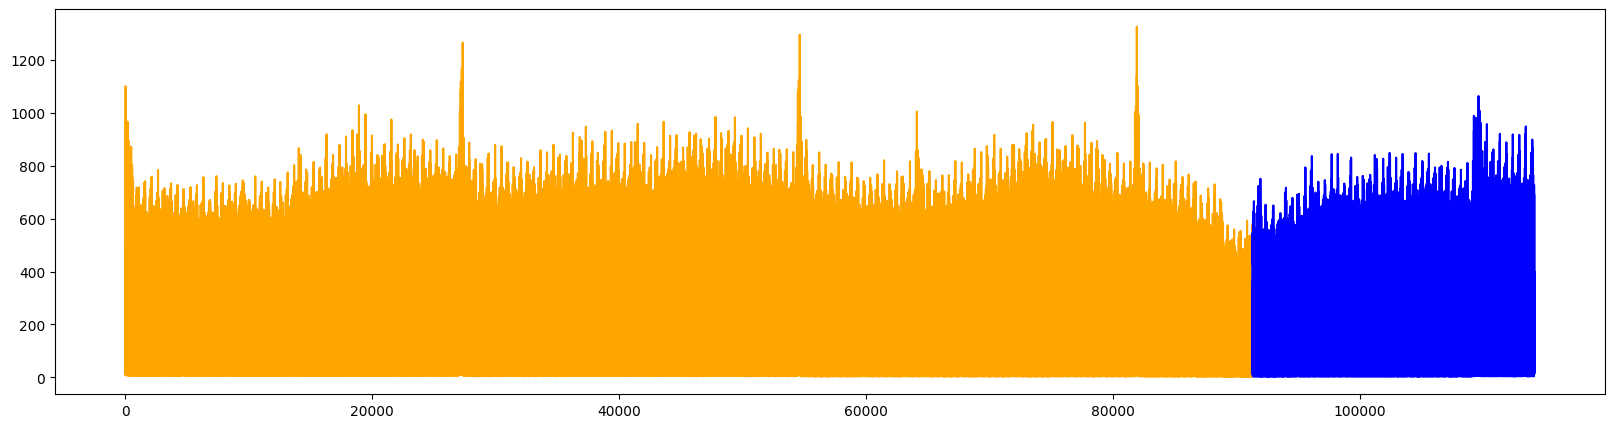

In [8]:
# get small split of data for hyperparameter tuning

train_index, val_index = [ x for x in TimeSeriesSplit(n_splits=5).split(df_train_0) ][-2]

X_train = df_train_0.iloc[train_index][model_features]
y_train = df_train_0.iloc[train_index]['num_sold']

X_val = df_train_0.iloc[val_index][model_features]
y_val = df_train_0.iloc[val_index]['num_sold']

# plot X_train and X_val
plt.figure(figsize=(20, 5))
plt.plot(X_train.index, y_train, color="orange", label='train')
plt.plot(X_val.index, y_val, color="blue", label='val')
plt.show()

In [23]:
X_train.info()

cat_features_indices = np.where((X_train.dtypes == "category") | (X_train.dtypes == "object"))[0]
cat_features_indices

<class 'pandas.core.frame.DataFrame'>
Index: 91300 entries, 0 to 91299
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   country      91300 non-null  category
 1   store        91300 non-null  category
 2   product      91300 non-null  category
 3   year         91300 non-null  int32   
 4   month        91300 non-null  int32   
 5   day          91300 non-null  int32   
 6   week_number  91300 non-null  int32   
 7   dayofweek    91300 non-null  int32   
 8   weekend      91300 non-null  int32   
dtypes: category(3), int32(6)
memory usage: 3.0 MB


array([0, 1, 2], dtype=int64)

In [26]:
def objective(trial):
    model=CatBoostRegressor(
        iterations = trial.suggest_int('iterations', 100, 300),
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
        depth = trial.suggest_int('depth', 1, 10), # depth above 10 usually introduces overfitting
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.2, 10),
        early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 1, 20),
        loss_function='RMSE', verbose=False
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[( X_train, y_train), ( X_val, y_val)],
        verbose=False,
        cat_features=cat_features_indices,
    )

    return SMAPE(y_val, np.round(model.predict(X_val)))


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_hyperparams = study.best_params

[I 2023-07-29 12:42:02,083] A new study created in memory with name: no-name-fc933c46-afaa-45c1-a312-64d2953ae5a0


[I 2023-07-29 12:42:03,393] Trial 0 finished with value: 64.11246739156391 and parameters: {'iterations': 292, 'learning_rate': 0.17633231213734923, 'depth': 1, 'l2_leaf_reg': 3.6198898461576117, 'early_stopping_rounds': 7}. Best is trial 0 with value: 64.11246739156391.
[I 2023-07-29 12:42:04,333] Trial 1 finished with value: 16.523366344793494 and parameters: {'iterations': 294, 'learning_rate': 0.19508072433739182, 'depth': 5, 'l2_leaf_reg': 2.8713432455811283, 'early_stopping_rounds': 4}. Best is trial 1 with value: 16.523366344793494.
[I 2023-07-29 12:42:10,340] Trial 2 finished with value: 63.97804081740564 and parameters: {'iterations': 225, 'learning_rate': 0.002757983799657413, 'depth': 5, 'l2_leaf_reg': 0.39389954367078417, 'early_stopping_rounds': 4}. Best is trial 1 with value: 16.523366344793494.
[I 2023-07-29 12:42:13,467] Trial 3 finished with value: 14.970914422958648 and parameters: {'iterations': 108, 'learning_rate': 0.07040706501768094, 'depth': 6, 'l2_leaf_reg': 1.

In [27]:
best_hyperparams

{'iterations': 154,
 'learning_rate': 0.2977031752287107,
 'depth': 7,
 'l2_leaf_reg': 6.41516807566864,
 'early_stopping_rounds': 6}

In [41]:
# split into train and validation


results_smape = []
results_r2 = []
results_mse = []


N_SPLITS = 5

for train_index, val_index in TimeSeriesSplit(n_splits=N_SPLITS).split(df_train_0):
    X_train = df_train_0.iloc[train_index][model_features]
    y_train = df_train_0.iloc[train_index]['num_sold']

    X_val = df_train_0.iloc[val_index]
    y_val = df_train_0.iloc[val_index]['num_sold']
      
    model = CatBoostRegressor(**best_hyperparams)
    model.fit(X_train, y_train, cat_features=cat_features_indices,)

    # evaluate on validation set
    y_pred = np.round(model.predict(X_val[model_features]))

    smape = SMAPE(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    results_smape.append(smape)
    results_r2.append(r2)
    results_mse.append(mse)
    del model

print("Cross validated results:")

print("SMAPE: %s" % results_smape)
print("R2: %s" % results_r2)
print("MSE: %s" % results_mse)

print("Mean results:")
print("SMAPE: %.4f" % np.mean(results_smape))
print("R2: %.4f" % np.mean(results_r2))
print("MSE: %.4f" % np.mean(results_mse))


# add a row with results to csv file leaderboard.csv

row = [model_name, np.mean(results_smape), np.mean(results_r2), np.mean(results_mse)]
with open('leaderboard.csv', 'a') as fd:
    import csv
    fd.write('\n')
    writer = csv.writer(fd, delimiter=',', lineterminator=';\n')
    writer.writerow(row)

0:	learn: 148.7344079	total: 29ms	remaining: 4.43s
1:	learn: 135.7306301	total: 51.8ms	remaining: 3.93s
2:	learn: 114.3416228	total: 80.4ms	remaining: 4.04s
3:	learn: 85.1998314	total: 107ms	remaining: 4s
4:	learn: 64.6925951	total: 133ms	remaining: 3.97s
5:	learn: 51.5651157	total: 162ms	remaining: 3.98s
6:	learn: 43.0536139	total: 189ms	remaining: 3.97s
7:	learn: 38.0168368	total: 215ms	remaining: 3.92s
8:	learn: 35.6341053	total: 241ms	remaining: 3.88s
9:	learn: 33.3356333	total: 270ms	remaining: 3.88s
10:	learn: 31.9146059	total: 301ms	remaining: 3.92s
11:	learn: 30.7360290	total: 332ms	remaining: 3.93s
12:	learn: 30.3094904	total: 362ms	remaining: 3.92s
13:	learn: 30.0009926	total: 393ms	remaining: 3.92s
14:	learn: 29.3021236	total: 423ms	remaining: 3.92s
15:	learn: 29.2920738	total: 434ms	remaining: 3.74s
16:	learn: 28.9417241	total: 463ms	remaining: 3.73s
17:	learn: 28.7735236	total: 506ms	remaining: 3.83s
18:	learn: 28.5753963	total: 533ms	remaining: 3.79s
19:	learn: 28.5695913

In [32]:
# train on full data
X_train = df_train_0.drop('num_sold', axis=1)
y_train = df_train_0['num_sold']


model = CatBoostRegressor(**best_hyperparams)
model.fit(X_train, y_train, cat_features=cat_features_indices,)

0:	learn: 159.9085078	total: 43.3ms	remaining: 6.63s
1:	learn: 146.5505222	total: 87.3ms	remaining: 6.63s
2:	learn: 125.1555327	total: 130ms	remaining: 6.53s
3:	learn: 92.7204628	total: 172ms	remaining: 6.44s
4:	learn: 71.0505967	total: 212ms	remaining: 6.31s
5:	learn: 56.4145493	total: 252ms	remaining: 6.22s
6:	learn: 47.1375313	total: 297ms	remaining: 6.24s
7:	learn: 40.8371867	total: 337ms	remaining: 6.14s
8:	learn: 36.5339514	total: 378ms	remaining: 6.09s
9:	learn: 33.7590313	total: 424ms	remaining: 6.11s
10:	learn: 32.0574568	total: 478ms	remaining: 6.22s
11:	learn: 30.7435361	total: 523ms	remaining: 6.19s
12:	learn: 29.7465286	total: 566ms	remaining: 6.14s
13:	learn: 28.6266877	total: 605ms	remaining: 6.05s
14:	learn: 27.7737651	total: 645ms	remaining: 5.98s
15:	learn: 27.1554142	total: 685ms	remaining: 5.91s
16:	learn: 26.3268118	total: 736ms	remaining: 5.93s
17:	learn: 25.7470075	total: 772ms	remaining: 5.83s
18:	learn: 25.1853923	total: 812ms	remaining: 5.77s
19:	learn: 24.817

In [34]:
df_val = X_val.copy()
df_val['actual'] = y_val
df_val['prediction'] = model.predict(df_val[model_features])
df_val['prediction'] = df_val['prediction'].astype(int)
df_val

,country,store,product,num_sold,year,month,day,week_number,dayofweek,weekend,date,actual,prediction
114125,Japan,Kaggle Store,Using LLMs to Improve Your Coding,149,2021,3,2,9,1,0,2021-03-02,149,144
114149,Spain,Kagglazon,Using LLMs to Write Better,390,2021,3,2,9,1,0,2021-03-02,390,404
114148,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,396,2021,3,2,9,1,0,2021-03-02,396,386
114147,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,72,2021,3,2,9,1,0,2021-03-02,72,67
114146,Spain,Kagglazon,Using LLMs to Train More LLMs,417,2021,3,2,9,1,0,2021-03-02,417,405
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136896,Canada,Kaggle Store,Using LLMs to Train More LLMs,360,2021,12,31,52,4,1,2021-12-31,360,346
136895,Canada,Kaggle Store,Using LLMs to Improve Your Coding,383,2021,12,31,52,4,1,2021-12-31,383,346
136894,Canada,Kaggle Learn,Using LLMs to Write Better,178,2021,12,31,52,4,1,2021-12-31,178,185
136901,Canada,Kagglazon,Using LLMs to Train More LLMs,1333,2021,12,31,52,4,1,2021-12-31,1333,1259


C:\Users\Wiktor\AppData\Local\Temp\ipykernel_12692\448301185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))
C:\Users\Wiktor\AppData\Local\Temp\ipykernel_12692\448301185.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.sort_values(by='date', inplace=True)


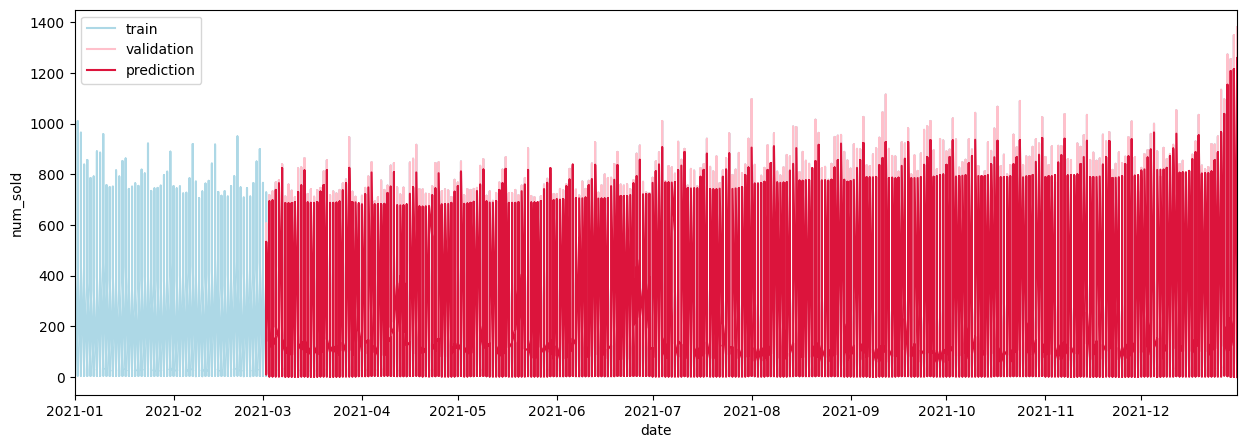

In [39]:
import datetime
X_train['date'] = pd.to_datetime(X_train['year'].astype(str) + '-' + X_train['month'].astype(str) + '-' + X_train['day'].astype(str))
X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))

# sort by date
X_train.sort_values(by='date', inplace=True)
X_val.sort_values(by='date', inplace=True)

# plot 'num_sold' vs 'date'
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(X_train['date'], y_train, label='train', color='lightblue')
ax.plot(X_val['date'], y_val, label='validation', color='pink')
ax.plot(df_val['date'], df_val['prediction'], label='prediction', color='crimson')

# x axis show only from 2021 onwards
ax.set_xlim([datetime.date(2021, 1, 1), df_val['date'].max()])
ax.set_xlabel('date')
ax.set_ylabel('num_sold')

ax.legend()
plt.show()

In [37]:
# test 

df_test = pd.read_csv(data_path + "test.csv")

df_test['date'] = pd.to_datetime(df_test['date'])

df_test = create_features(df_test)
# predict for test set

df_test['prediction'] = model.predict(df_test[model_features])
df_test['prediction'] = df_test['prediction'].astype(int)
df_test

,id,country,store,product,year,month,day,week_number,dayofweek,weekend,prediction
0,136950,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,52,5,1,36
1,136951,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,52,5,1,36
2,136952,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,52,5,1,5
3,136953,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,52,5,1,35
4,136954,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,52,5,1,28
...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,52,5,1,732
27371,164321,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,52,5,1,739
27372,164322,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,52,5,1,111
27373,164323,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,52,5,1,686


In [38]:
df_test['num_sold'] = df_test['prediction']
df_test[['id', 'num_sold']].to_csv('first_submission.csv', index=False)